## Seoul Bike Sharing - Artificial Neural Network using Pytorch

Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.

In this project, we will predict the demand of bikes per hour in the Seoul Bike Sharing System. For this regression problem we are going to build an artificial neural network using Pytorch library.

The dataset is provided in the UCI Machine Learning Repository, in the link https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand .

In [286]:
# Importing the libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [287]:
#Loading the dataset
df=pd.read_csv('SeoulBikeData.csv', encoding='unicode_escape')

In [288]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [289]:
df.shape

(8760, 14)

Below we can see the data dictionary, provided in UCI Machine Learning Repository:

- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour
- Hour - Hour of he day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

##  EDA and Data Prepocessing


In [290]:
#No missing values
df.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [291]:
#Let's take a look at the dtype of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

Let's make a descriptive stattistics on the target, "Rented Bike Count".

In [292]:
df['Rented Bike Count'].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Rented Bike Count, dtype: float64

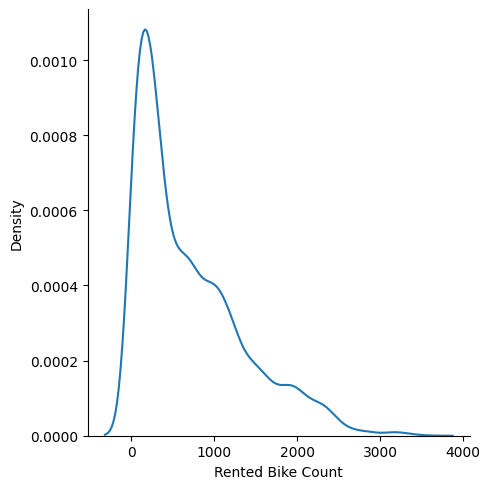

In [293]:
#The distribution is asymmetric to the right.
sns.displot(df['Rented Bike Count'], kind='kde')

Let's take a look at the feature "Functioning Day". We are going to audit the dataset. All the rows that "Functioning Day" is "No", "Rented Bike Count" should be 0.

If my assumption is correct, we are going to drop the rows that have "No" in "Functioning Day" and then drop "Functioning Day" column. This data don't agreggate any information to our model.

In [294]:
# 295 "No" rows.
df['Functioning Day'].value_counts()

Yes    8465
No      295
Name: Functioning Day, dtype: int64

In [295]:
#Obviously, as we assumed, with no Functioning Day there are no Bike Rental.
df.loc[df['Functioning Day']=='No','Rented Bike Count'].unique()

array([0])

In [296]:
#Dropping no functioning days' rows.
df.drop(df.loc[df['Functioning Day']=='No'].index,inplace=True)

In [297]:
#Dropping "Functioning Day" column.
df.drop('Functioning Day', axis=1,inplace=True)

Now, we are going to make a feature engeneering using the "Date" feature. We are going to build the features "Month", "Weekday" and "Year".

In [298]:
# Converting the dtype of "Date" from object to datetime in order to start our feature engeneering.
df['Date']=pd.to_datetime(df['Date'])

<ipython-input-298-88502500799d>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date']=pd.to_datetime(df['Date'])


In [299]:
#Dtype of "Date" is datetime.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8465 non-null   datetime64[ns]
 1   Rented Bike Count          8465 non-null   int64         
 2   Hour                       8465 non-null   int64         
 3   Temperature(°C)            8465 non-null   float64       
 4   Humidity(%)                8465 non-null   int64         
 5   Wind speed (m/s)           8465 non-null   float64       
 6   Visibility (10m)           8465 non-null   int64         
 7   Dew point temperature(°C)  8465 non-null   float64       
 8   Solar Radiation (MJ/m2)    8465 non-null   float64       
 9   Rainfall(mm)               8465 non-null   float64       
 10  Snowfall (cm)              8465 non-null   float64       
 11  Seasons                    8465 non-null   object        
 12  Holida

In [300]:
# Date is in the format YYYY-MM-DD. We can see that the data started to be collected in january of 2017 and ended in december of 2018.
df['Date'].describe()

<ipython-input-300-ad5b1189a17a>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['Date'].describe()


count                    8465
unique                    353
top       2017-01-12 00:00:00
freq                       24
first     2017-01-12 00:00:00
last      2018-12-11 00:00:00
Name: Date, dtype: object

From the date, we can pick the year, month and day of the week.

In [301]:
df['Month']=df['Date'].apply(lambda x: x.month)
df['Weekday']=df['Date'].apply(lambda x: x.strftime("%A"))
df['Year']=df['Date'].apply(lambda x: x.year)

In [302]:
#Now let's drop the date, cause we won't use it anymore.
df.drop('Date',axis=1,inplace=True)

As we are going to build an artificial neural network, we have to transform our pandas dataset in pytorch tensors. For that, first we'll divide de features in categorycal and continuos, once the preprocessing of one group is different from the preprocessig of the other.



In [303]:
#Shuffling the data
df = df.sample(frac = 1).reset_index(drop=True)
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Month,Weekday,Year
0,2377,21,22.6,62,1.1,1363,14.9,0.00,0.0,0.0,Summer,No Holiday,4,Friday,2018
1,595,10,3.9,28,0.6,1627,-12.9,0.49,0.0,0.0,Autumn,No Holiday,11,Thursday,2018
2,1808,20,33.2,51,1.0,2000,21.6,0.02,0.0,0.0,Summer,No Holiday,8,Wednesday,2018
3,522,17,5.7,36,3.0,1073,-8.2,0.57,0.0,0.0,Winter,No Holiday,2,Monday,2018
4,3245,18,26.0,39,2.7,1950,10.9,1.07,0.0,0.0,Spring,No Holiday,5,Monday,2018


In [304]:
#dividing the columns in categorycal, continuous and the target.
cat_cols=['Month','Hour','Seasons',
       'Holiday',  'Weekday', 'Year']
cont_cols=['Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
y_col=['Rented Bike Count']


Let's treat first our categorycal columns and turn them into a tensor. Then we are going to build an embbeding layer as a part of the preprocessing.

In [305]:
#Let's categorify our cat_cols.
for col in cat_cols:
  df[col]=df[col].astype('category')

In [306]:
#Now we are going to turn our cat_cols into an array of numbers and then concatenate them so we can turn them into a tensor.
cats = np.stack([df[col].cat.codes.values for col in cat_cols],axis=1)
cats

array([[ 3, 21,  2,  1,  0,  1],
       [10, 10,  0,  1,  4,  1],
       [ 7, 20,  2,  1,  6,  1],
       ...,
       [10, 23,  3,  1,  4,  1],
       [ 4, 11,  3,  1,  6,  1],
       [ 9, 20,  0,  1,  6,  1]], dtype=int8)

In [307]:
#Converting our categorycal array into a tensor.
cats = torch.tensor(cats, dtype=torch.int64)
cats

tensor([[ 3, 21,  2,  1,  0,  1],
        [10, 10,  0,  1,  4,  1],
        [ 7, 20,  2,  1,  6,  1],
        ...,
        [10, 23,  3,  1,  4,  1],
        [ 4, 11,  3,  1,  6,  1],
        [ 9, 20,  0,  1,  6,  1]])

In [308]:
cats.type()

'torch.LongTensor'

In [309]:
# This line of code is going to set the parameters that will be used as the input of the embbeding layer, that will be part of our ANN. Each tuple shows the number of different categories for each feature and the embbeding size.
cat_szs=[len(df[col].cat.categories) for col in cat_cols]
emb_szs=[(size,min(50,(size+1)//2)) for size in cat_szs]
emb_szs

[(12, 6), (24, 12), (4, 2), (2, 1), (7, 4), (2, 1)]

Now we are going to turn our continuous features into tensors.

In [310]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[ 2.2600e+01,  6.2000e+01,  1.1000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.9000e+00,  2.8000e+01,  6.0000e-01,  ...,  4.9000e-01,
          0.0000e+00,  0.0000e+00],
        [ 3.3200e+01,  5.1000e+01,  1.0000e+00,  ...,  2.0000e-02,
          0.0000e+00,  0.0000e+00],
        ...,
        [-1.3200e+01,  5.1000e+01,  1.5000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-8.5000e+00,  2.7000e+01,  4.7000e+00,  ...,  1.7300e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.2200e+01,  4.7000e+01,  1.1000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [311]:
conts.type()

'torch.FloatTensor'

Converting the target to a tensor.

In [312]:
y = torch.tensor(df[y_col].values, dtype=torch.float)
y

tensor([[2377.],
        [ 595.],
        [1808.],
        ...,
        [ 119.],
        [ 156.],
        [1558.]])

In [313]:
y.type()

'torch.FloatTensor'

#Creating, Training and Validating the Model

Now, since we have all the inputs turned into tensors, finally we can build our artificial neural network. For that, we are going to use Pytorch and build a class called Tabular Model.

This class will define the preprocessing that are going to be used in categorycal and continuous features and the configuration of our neural network.

The schema below shows how our ANN will work. Despite the schema shows after the preprocessing two combinations of Linear + Relu + Batch Norm + Dropout, we can use any number of combinations we want.

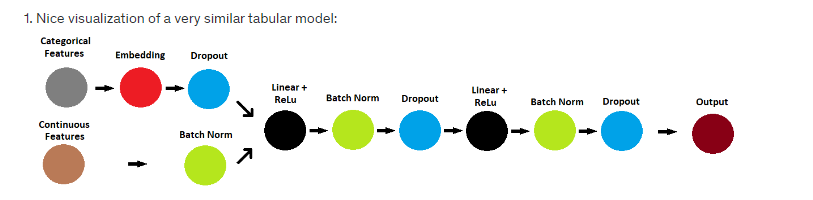

In [314]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [315]:
#Setting the manual seed for reasons of reproducibility and then passing an ANN of two hidden layers, the first one with 200 neurons and the second with 100 neuron. The dropout probability per each layer will be 0.2.
torch.manual_seed(42)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.2)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(24, 12)
    (2): Embedding(4, 2)
    (3): Embedding(2, 1)
    (4): Embedding(7, 4)
    (5): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=34, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [316]:
# Setting the Loss Function and Optimizer. We are going to use the Mean Squared Error as a loss function and ADAM as the optimizer. The learning rate will be 0.001.
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [317]:
#Making the data Sampling.
test_size=int(0.5*len(cats))
cat_train = cats[:test_size]
cat_test = cats[test_size:]
con_train = conts[:test_size]
con_test = conts[test_size:]
y_train = y[:test_size]
y_test = y[test_size:]

Let's train our model and estimate the parameters using backpropagation. We will compute the the training and validation losses.

We will use 3000 epochs and show the results from 50 to 50 epochs.

In [318]:
import time
start_time = time.time()

epochs = 3000
losses = []
losses_val=[]
for i in range(epochs):
    i+=1
    y_pred = model.forward(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    with torch.no_grad():
      y_val = model.forward(cat_test, con_test)
      loss_val = torch.sqrt(criterion(y_val, y_test))
      losses_val.append(loss_val)

    if i%50 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}  loss_val: {loss_val.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the  line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 970.32336426  loss_val: 973.23297119
epoch:  51  loss: 965.06713867  loss_val: 967.92163086
epoch: 101  loss: 959.13049316  loss_val: 962.02233887
epoch: 151  loss: 951.76983643  loss_val: 954.65594482
epoch: 201  loss: 942.81884766  loss_val: 945.83038330
epoch: 251  loss: 931.91485596  loss_val: 935.01422119
epoch: 301  loss: 919.95971680  loss_val: 923.08258057
epoch: 351  loss: 906.22729492  loss_val: 909.93719482
epoch: 401  loss: 891.38677979  loss_val: 894.81835938
epoch: 451  loss: 874.76562500  loss_val: 878.99542236
epoch: 501  loss: 856.89965820  loss_val: 861.07635498
epoch: 551  loss: 837.12951660  loss_val: 842.24523926
epoch: 601  loss: 817.03399658  loss_val: 821.54156494
epoch: 651  loss: 794.20886230  loss_val: 800.10467529
epoch: 701  loss: 771.80792236  loss_val: 777.22808838
epoch: 751  loss: 746.84863281  loss_val: 753.23730469
epoch: 801  loss: 721.03851318  loss_val: 727.97448730
epoch: 851  loss: 694.05541992  loss_val: 701.06579590
epoch: 901

Plotting the losses to show our model convergence.

In [319]:
#To plot the losses, first we have to detach the tensor from the current computing graph.
losses_plot=[]
losses_val_plot=[]
for loss,loss_val in zip(losses,losses_val):
  losses_plot.append(loss.detach().numpy())
  losses_val_plot.append(loss_val.detach().numpy())

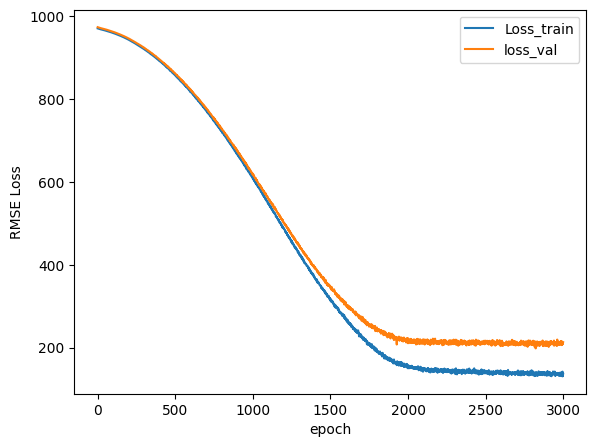

In [320]:
#Start converging about the 2000 epoch
fig=plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.plot(range(epochs), losses_plot, label="Loss_train")
plt.plot(range(epochs), losses_val_plot, label="loss_val")
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')
axes.legend()

In [321]:
#Printing the 50 real values in the validation dataset, our model prediction and the difference between them. As we are talking about integer numbers, the output of our ANN were rounded.
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(round(y_val[i].item())-y_test[i].item())
    print(f'{i+1:2}.   {round(y_val[i].item())}   {y_test[i].item()}      {diff}')

   PREDICTED   ACTUAL     DIFF
 1.   693   819.0      126.0
 2.   447   448.0      1.0
 3.   787   425.0      362.0
 4.   122   29.0      93.0
 5.   2328   2066.0      262.0
 6.   1585   1407.0      178.0
 7.   899   1059.0      160.0
 8.   629   639.0      10.0
 9.   275   141.0      134.0
10.   245   177.0      68.0
11.   756   839.0      83.0
12.   569   1024.0      455.0
13.   407   434.0      27.0
14.   1130   1097.0      33.0
15.   282   237.0      45.0
16.   124   78.0      46.0
17.   225   304.0      79.0
18.   1305   1571.0      266.0
19.   192   177.0      15.0
20.   27   36.0      9.0
21.   1264   1280.0      16.0
22.   1477   1236.0      241.0
23.   2996   3196.0      200.0
24.   1026   1158.0      132.0
25.   207   327.0      120.0
26.   17   37.0      20.0
27.   674   719.0      45.0
28.   224   164.0      60.0
29.   886   1003.0      117.0
30.   246   354.0      108.0
31.   1926   2022.0      96.0
32.   90   96.0      6.0
33.   258   346.0      88.0
34.   106   28.0     

# Conclusion

The project was successfull in what it proposed. Using an ANN built with pytorch, we got a RMSE for the validation dataset about 210~220, that converged in about 2000 epochs. The high number of epochs to converge is a consequence of the small learning rate chosen, that was not a problem, since the duration of the training was not that high. This lr was chosen in a way that the network doesn't overshoot the optimal point and oscillate around it. Another point to be highlighted is that the regularization methods used fulfilled their role, as we can see from the losses' graphs that there is no overfitting.

In addition to solving the specific problem, to presenting several concepts in deep learning, the ANN used in this notebook can be reproducible for different kinds of tabular problems.
